In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import featureman.gen_data as man
from sklearn.cluster import SpectralClustering
import pickle
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
sae_dict = torch.load("sae_synthetic.pth", map_location=device)
sae = man.BatchedSAE_Updated(input_dim=128, n_models=5, width_ratio=4).to(device)
#model 3 is cool, l0 of ~10
sae.load_state_dict(sae_dict)

<All keys matched successfully>

In [7]:
decoder = sae.W_d[3]

#decoder normalize
decoder = decoder / decoder.norm(dim=1, keepdim=True)

all_sims = decoder @ decoder.T

all_sims.shape

torch.Size([512, 512])

In [ ]:
all_sims.fill_diagonal_(0)  # Set diagonal to zero
#normalize all_sims
all_sims = torch.clamp(all_sims, -1, 1)
all_sims = 1 - torch.arccos(all_sims) / np.pi
all_sims = all_sims.detach().cpu().numpy()
def spectral_cluster_sims(all_sims, n_clusters=250):
    sc = SpectralClustering(n_clusters=n_clusters, affinity="precomputed")
    labels = sc.fit_predict(all_sims).tolist()
    clusters = [[] for _ in range(n_clusters)]
    for i, label in enumerate(labels):
        clusters[label].append(i)
    pickle.dump(
        clusters,
        open(f"syn_sae_clusters.pkl", "wb"),
    )
sc = spectral_cluster_sims(all_sims, n_clusters=250)

In [ ]:
# load the clusters
with open("syn_sae_clusters.pkl", "rb") as f:
    clusters = pickle.load(f)


In [10]:
clusters = [c for c in clusters if len(c) > 1]  # Filter out clusters with only one element
clusters = sorted(clusters, key=lambda x: len(x), reverse=True)  # Sort by size

In [11]:
#import pca
from sklearn.decomposition import PCA
from tqdm import tqdm

pcas = []
for c in tqdm(clusters):
    pca = PCA()
    pcas.append((pca, pca.fit_transform(sae.W_d[3][c].detach().cpu().numpy())))

100%|██████████| 36/36 [00:00<00:00, 458.66it/s]


In [12]:
pcas[0][1].shape

(174, 128)

In [13]:
pcas[0][0].explained_variance_ratio_

array([3.47389914e-02, 3.44133787e-02, 3.29882391e-02, 2.06319820e-02,
       1.77994110e-02, 1.76551118e-02, 1.75512135e-02, 1.73716582e-02,
       1.72102563e-02, 1.71428006e-02, 1.68865100e-02, 1.65780447e-02,
       1.65151432e-02, 1.61258541e-02, 1.57985594e-02, 1.54743157e-02,
       1.51613206e-02, 1.50064761e-02, 1.45478724e-02, 1.44725954e-02,
       1.41686322e-02, 1.40675697e-02, 1.38722025e-02, 1.38349216e-02,
       1.35124130e-02, 1.33174350e-02, 1.31948693e-02, 1.27988765e-02,
       1.26166390e-02, 1.25479111e-02, 1.21717891e-02, 1.19750211e-02,
       1.18106147e-02, 1.18076168e-02, 1.15239592e-02, 1.13049913e-02,
       1.11398138e-02, 1.10270279e-02, 1.08581083e-02, 1.06229801e-02,
       1.03750024e-02, 1.01592587e-02, 1.00367833e-02, 9.96386819e-03,
       9.85847693e-03, 9.66092013e-03, 9.40840598e-03, 9.09507368e-03,
       9.02893208e-03, 8.93192459e-03, 8.67950357e-03, 8.49730056e-03,
       8.29371810e-03, 8.06212239e-03, 8.00466537e-03, 7.78983952e-03,
      

# what to do next
- decoder/dict_atoms -> sae_hidden x mlp_dim
- relu_acts -> sae_hidden
- out -> mlp_dim

- concat(samples X filtered_sae_hidden) x mlp_dim
- einop('s f m -> (s f) m')
- PCA of that stuff

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (9,) and arg 1 with shape (6,).

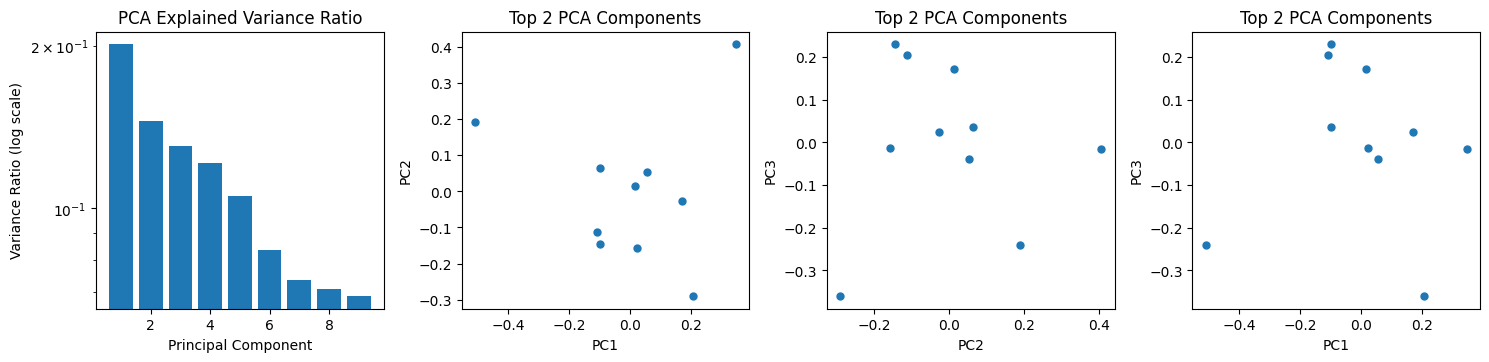

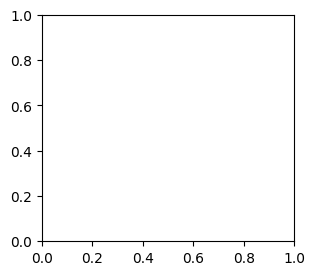

In [17]:
for i in range(2, 10):
    fig = plt.figure(figsize=(15, 10))

    ax1 = plt.subplot(3, 4, 1)
    ax1.bar(range(1,10), pcas[i][0].explained_variance_ratio_[:9])
    ax1.set_yscale('log')
    ax1.set_title('PCA Explained Variance Ratio')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Variance Ratio (log scale)')

    ax2 = plt.subplot(3, 4, 2)
    ax2.plot(pcas[i][1][:, 0], pcas[i][1][:, 1], 'o', markersize=5)
    ax2.set_title('Top 2 PCA Components')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')

    ax3 = plt.subplot(3, 4, 3)
    ax3.plot(pcas[i][1][:, 1], pcas[i][1][:, 2], 'o', markersize=5)
    ax3.set_title('Top 2 PCA Components')
    ax3.set_xlabel('PC2')
    ax3.set_ylabel('PC3')

    ax4 = plt.subplot(3, 4, 4)
    ax4.plot(pcas[i][1][:, 0], pcas[i][1][:, 2], 'o', markersize=5)
    ax4.set_title('Top 2 PCA Components')
    ax4.set_xlabel('PC1')
    ax4.set_ylabel('PC3')

    plt.tight_layout()

plt.show()